In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import copy

In [2]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled)


## Build model architecture

In [3]:
def convblock(cdim, nb, has3=True):
    L = []
    #L.append( ZeroPadding2D((1, 1)) )
    L.append( Convolution2D(cdim, 3, 3, border_mode='same', activation='relu', name='conv'+str(nb)+'_1'))
    #L.append( ZeroPadding2D((1, 1)) )
    L.append( Convolution2D(cdim, 3, 3, border_mode='same', activation='relu', name='conv'+str(nb)+'_2') )
    if has3:
        #L.append( ZeroPadding2D((1, 1)) )
        L.append( Convolution2D(cdim, 3, 3, border_mode='same', activation='relu', name='conv'+str(nb)+'_3') )
    L.append( MaxPooling2D((2, 2), strides=(2, 2)) )
    return L


def vgg_face_blank():
    
    withDO = True # no effect during evaluation
    
    if True:
        mdl = Sequential()
        #mdl.add(Lambda(lambda x : x, input_shape=(3,224,224)))

        #mdl.add( ZeroPadding2D(padding=(1, 1)) )
        mdl.add( Convolution2D(64, 3, 3, border_mode='same', activation='relu', name='conv1_1', input_shape=(3,224,224)) )
        #mdl.add( ZeroPadding2D(padding=(1, 1)) )
        mdl.add( Convolution2D(64, 3, 3, border_mode='same', activation='relu', name='conv1_2') )
        mdl.add( MaxPooling2D((2, 2), strides=(2, 2)) )

        for l in convblock(128, 2, False):
            mdl.add(l)
        
        for l in convblock(256, 3, True):
            mdl.add(l)
            
        for l in convblock(512, 4, True):
            mdl.add(l)
            
        for l in convblock(512, 5, True):
            mdl.add(l)
        
        mdl.add( Convolution2D(4096, 7, 7, activation='relu', name='fc6') )
        if withDO:
            mdl.add( Dropout(0.5) )
        mdl.add( Convolution2D(4096, 1, 1, activation='relu', name='fc7') )
        if withDO:
            mdl.add( Dropout(0.5) )
        
        mdl.add( Convolution2D(2622, 1, 1, name='fc8') )
        mdl.add( Flatten() )
        mdl.add( Activation('softmax') )
        
        return mdl
    
    else:
        # adapted from this page : gist.github.com/EncodeTS/6bbe8cb8bebad7a672f0d872561782d9
        img = Input(shape=(3, 224, 224))
        #pad1_1 = ZeroPadding2D(padding=(1, 1))(img)
        pad1_1 = img
        conv1_1 = Convolution2D(64, 3, 3, border_mode='same', activation='relu', name='conv1_1')(pad1_1)
        #pad1_2 = ZeroPadding2D(padding=(1, 1))(conv1_1)
        pad1_2 = conv1_1
        conv1_2 = Convolution2D(64, 3, 3, border_mode='same', activation='relu', name='conv1_2')(pad1_2)
        pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1_2)

        #pad2_1 = ZeroPadding2D((1, 1))(pool1)
        pad2_1 = pool1
        conv2_1 = Convolution2D(128, 3, 3, border_mode='same', activation='relu', name='conv2_1')(pad2_1)
        #pad2_2 = ZeroPadding2D((1, 1))(conv2_1)
        pad2_2 = conv2_1
        conv2_2 = Convolution2D(128, 3, 3, border_mode='same', activation='relu', name='conv2_2')(pad2_2)
        pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2_2)

        #pad3_1 = ZeroPadding2D((1, 1))(pool2)
        pad3_1 = pool2
        conv3_1 = Convolution2D(256, 3, 3, border_mode='same', activation='relu', name='conv3_1')(pad3_1)
        #pad3_2 = ZeroPadding2D((1, 1))(conv3_1)
        pad3_2 = conv3_1
        conv3_2 = Convolution2D(256, 3, 3, border_mode='same', activation='relu', name='conv3_2')(pad3_2)
        #pad3_3 = ZeroPadding2D((1, 1))(conv3_2)
        pad3_3 = conv3_2
        conv3_3 = Convolution2D(256, 3, 3, border_mode='same', activation='relu', name='conv3_3')(pad3_3)
        pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3_3)

        #pad4_1 = ZeroPadding2D((1, 1))(pool3)
        pad4_1 = pool3
        conv4_1 = Convolution2D(512, 3, 3, border_mode='same', activation='relu', name='conv4_1')(pad4_1)
        #pad4_2 = ZeroPadding2D((1, 1))(conv4_1)
        pad4_2 = conv4_1
        conv4_2 = Convolution2D(512, 3, 3, border_mode='same', activation='relu', name='conv4_2')(pad4_2)
        #pad4_3 = ZeroPadding2D((1, 1))(conv4_2)
        pad4_3 = conv4_2
        conv4_3 = Convolution2D(512, 3, 3, border_mode='same', activation='relu', name='conv4_3')(pad4_3)
        pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4_3)

        #pad5_1 = ZeroPadding2D((1, 1))(pool4)
        pad5_1 = pool4
        conv5_1 = Convolution2D(512, 3, 3, border_mode='same', activation='relu', name='conv5_1')(pad5_1)
        #pad5_2 = ZeroPadding2D((1, 1))(conv5_1)
        pad5_2 = conv5_1
        conv5_2 = Convolution2D(512, 3, 3, border_mode='same', activation='relu', name='conv5_2')(pad5_2)
        #pad5_3 = ZeroPadding2D((1, 1))(conv5_2)
        pad5_3 = conv5_2
        conv5_3 = Convolution2D(512, 3, 3, border_mode='same', activation='relu', name='conv5_3')(pad5_3)
        pool5 = MaxPooling2D((2, 2), strides=(2, 2))(conv5_3)

        fc6 = Convolution2D(4096, 7, 7, activation='relu', name='fc6')(pool5)
        if withDO:
            fc6_drop = Dropout(0.5)(fc6)
        else:
            fc6_drop = fc6
        fc7 = Convolution2D(4096, 1, 1, activation='relu', name='fc7')(fc6_drop)
        if withDO:
            fc7_drop = Dropout(0.5)(fc7)
        else:
            fc7_drop = fc7
        fc8 = Convolution2D(2622, 1, 1, name='fc8')(fc7_drop)
        flat = Flatten()(fc8)
        out = Activation('softmax')(flat)

        model = Model(input=img, output=out)

        return model

In [4]:
facemodel = vgg_face_blank()

In [5]:
#facemodel.summary()

## Load VGG weigths from .mat file

#### http://www.vlfeat.org/matconvnet/pretrained/#face-recognition
##### Download from console with :
wget http://www.vlfeat.org/matconvnet/models/vgg-face.mat

##### Alternatively :
wget http://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_matconvnet.tar.gz

In [6]:
from scipy.io import loadmat

In [7]:
if False:
    data = loadmat('vgg-face.mat', matlab_compatible=False, struct_as_record=False)
    l = data['layers']
    description = data['meta'][0,0].classes[0,0].description
else:
    data = loadmat('vgg_face_matconvnet/data/vgg_face.mat', matlab_compatible=False, struct_as_record=False)
    net = data['net'][0,0]
    l = net.layers
    description = net.classes[0,0].description

In [8]:
l.shape, description.shape

((1, 39), (2622, 1))

In [9]:
l[0,10][0,0].type[0], l[0,10][0,0].name[0]

(u'conv', u'conv3_1')

In [10]:
l[0,10][0,0].weights[0,0].shape, l[0,10][0,0].weights[0,1].shape

((3, 3, 128, 256), (256, 1))

In [11]:
def weight_compare(kmodel):
    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (3,2,0,1) # WARNING : important setting as 2 of the 4 axis have same size dimension

    for i in range(l.shape[1]):
        matname = l[0,i][0,0].name[0]
        mattype = l[0,i][0,0].type[0]
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print matname, mattype
            print l[0,i][0,0].weights[0,0].transpose(prmt).shape, l[0,i][0,0].weights[0,1].shape
            print kmodel.layers[kindex].get_weights()[0].shape, kmodel.layers[kindex].get_weights()[1].shape
            print '------------------------------------------'
        else:
            print 'MISSING : ', matname, mattype
            print '------------------------------------------'

In [12]:
weight_compare(facemodel)

conv1_1 conv
(64, 3, 3, 3) (64, 1)
(64, 3, 3, 3) (64,)
------------------------------------------
MISSING :  relu1_1 relu
------------------------------------------
conv1_2 conv
(64, 64, 3, 3) (64, 1)
(64, 64, 3, 3) (64,)
------------------------------------------
MISSING :  relu1_2 relu
------------------------------------------
MISSING :  pool1 pool
------------------------------------------
conv2_1 conv
(128, 64, 3, 3) (128, 1)
(128, 64, 3, 3) (128,)
------------------------------------------
MISSING :  relu2_1 relu
------------------------------------------
conv2_2 conv
(128, 128, 3, 3) (128, 1)
(128, 128, 3, 3) (128,)
------------------------------------------
MISSING :  relu2_2 relu
------------------------------------------
MISSING :  pool2 pool
------------------------------------------
conv3_1 conv
(256, 128, 3, 3) (256, 1)
(256, 128, 3, 3) (256,)
------------------------------------------
MISSING :  relu3_1 relu
------------------------------------------
conv3_2 conv
(256, 25

In [13]:
def copy_mat_to_keras(kmodel):

    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (3,2,0,1) # WARNING : important setting as 2 of the 4 axis have same size dimension

    for i in range(l.shape[1]):
        matname = l[0,i][0,0].name[0]
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            #print matname
            l_weights = l[0,i][0,0].weights[0,0]
            l_bias = l[0,i][0,0].weights[0,1]
            f_l_weights = l_weights.transpose(prmt)
            f_l_weights = np.flip(f_l_weights, 2)
            f_l_weights = np.flip(f_l_weights, 3)
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])
            #print '------------------------------------------'

In [14]:
copy_mat_to_keras(facemodel)

In [26]:
#im = Image.open('Colin_Firth.jpg')
#im = Image.open('Aamir_Khan.jpg')
#im = Image.open('hugh_laurie.jpg')
im = Image.open('ak.png')
#im = Image.open('mzaradzki.jpg')
im = Image.open('someguy.jpg')
im = im.resize((224,224))

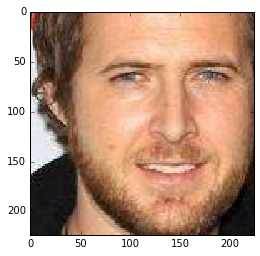

In [27]:
plt.imshow(np.asarray(im))

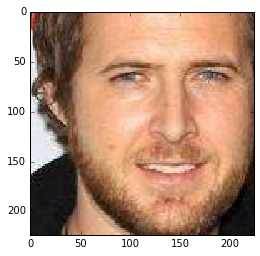

In [28]:
if False:
    left = 25
    top = 10
    width = 224
    height = 224
    box = (left, top, left+width, top+height)
    # Crop Image
    crpim = im.crop(box)#.resize((224,224))
else:
    crpim = im

plt.imshow(np.asarray(crpim))

In [29]:
def pred(kmodel, crpimg, transform=False):
    
    # transform=True seems more robust but I think the RGB channels are not in right order
    
    imarr = np.array(crpimg).astype(np.float32)

    if transform:
        imarr[:,:,0] -= 129.1863
        imarr[:,:,1] -= 104.7624
        imarr[:,:,2] -= 93.5940
        #
        # WARNING : in this script (https://github.com/rcmalli/keras-vggface) colours are switched
        aux = copy.copy(imarr)
        #imarr[:, :, 0] = aux[:, :, 2]
        #imarr[:, :, 2] = aux[:, :, 0]

        #imarr[:,:,0] -= 129.1863
        #imarr[:,:,1] -= 104.7624
        #imarr[:,:,2] -= 93.5940

    imarr = imarr.transpose((2,0,1))
    imarr = np.expand_dims(imarr, axis=0)

    out = kmodel.predict(imarr)

    best_index = np.argmax(out, axis=1)[0]
    best_name = description[best_index,0]
    print(best_index, best_name[0], out[0,best_index], [np.min(out), np.max(out)])

In [30]:
pred(facemodel, crpim, transform=False)
pred(facemodel, crpim, transform=True)

(0, u'A.J._Buckley', 0.99971837, [4.7208402e-16, 0.99971837])
(0, u'A.J._Buckley', 0.97920185, [4.7058996e-10, 0.97920185])


In [31]:
[(i, s[0]) for i, s in enumerate(description[:,0]) if ('laurie'.lower() in s[0].lower())]

[(861, u'Hugh_Laurie'), (1445, u'Laurie_Holden')]

In [32]:
description[100,0][0]

u'America_Ferrera'

## Face Feature Vector : drop the last layer

In [33]:
featuremodel = Model(input=facemodel.layers[0].input, output=facemodel.layers[-2].output)

In [34]:
def features(featmodel, crpimg, transform=False):
    
    # transform=True seems more robust but I think the RGB channels are not in right order
    
    imarr = np.array(crpimg).astype(np.float32)

    if transform:
        imarr[:,:,0] -= 129.1863
        imarr[:,:,1] -= 104.7624
        imarr[:,:,2] -= 93.5940
        #
        # WARNING : in this script (https://github.com/rcmalli/keras-vggface) colours are switched
        aux = copy.copy(imarr)
        #imarr[:, :, 0] = aux[:, :, 2]
        #imarr[:, :, 2] = aux[:, :, 0]

        #imarr[:,:,0] -= 129.1863
        #imarr[:,:,1] -= 104.7624
        #imarr[:,:,2] -= 93.5940

    imarr = imarr.transpose((2,0,1))
    imarr = np.expand_dims(imarr, axis=0)

    fvec = featmodel.predict(imarr)[0,:]
    # normalize
    normfvec = math.sqrt(fvec.dot(fvec))
    return fvec/normfvec

In [35]:
f = features(featuremodel, crpim, transform=True)

In [36]:
f.shape, f.dot(f)

((2622,), 1.0)